# **SMS Analysis: Spam or Ham (Beginner Level)**

This is my first project on Natural Language Processing (NLP), for which I chose the "SMS Spam Collection Dataset". This dataset contains the text of 5,572 SMS messages and their corresponding labels, classifying each message as "spam" or "ham".

In this notebook, I will explore several common NLP techniques, such as:

* **Removing Punctuation and Stopwords**
* **Tokenization & Bag of Words**
* **Term Frequency-Inverse Document Frequency (TF-IDF)**

Based on this preprocessing, I will train 6 different models to classify **unknown** messages as spam or ham:

* **Naive Bayes Classifier**
* **Support Vector Machine (SVM) Classifier**
* **K-Nearest Neighbors (KNN) Classifier**
* **Stochastic Gradient Descent (SGD) Classifier**
* **Gradient Boosting Classifier**
* **XGBoost Classifier**

To simplify the preprocessing workflow for training and testing data and to optimize different models under the same conditions, all classification tasks will be handled using **Pipelines** that include `GridSearchCV`. Finally, we will use various **evaluation metrics** to assess model performance, including accuracy, precision, recall, f1-score, and ROC AUC.

---

## **Notebook Outline**

* [**Part 0: Imports & Setup**](#part-0)
    * Import necessary libraries
    * Define helper functions
* [**Part 1: Exploratory Data Analysis (EDA)**](#part-1)
    * Dataset overview (`head`, `describe`, `value_counts`)
    * Distribution of the target variable
    * Add a numerical representation for labels
    * Analyze message length as a feature
    * Generate Word Clouds
* [**Part 2: Text Preprocessing**](#part-2)
    * Remove punctuation and stopwords
    * Analyze high-frequency words in ham vs. spam messages
    * Build a Bag of Words model with `CountVectorizer`
    * Calculate Term Frequency-Inverse Document Frequency (TF-IDF)
* [**Part 3: Building & Evaluating Classifiers**](#part-3)
    * Split the data into training and testing sets
    * Build classification Pipelines with `GridSearchCV` for hyperparameter tuning
    * Compare model performance using metrics (Confusion Matrix, Accuracy, Precision, Recall, F1-Score, ROC AUC)
    * Optimize models for different evaluation metrics (Precision, Recall)
* [**Part 4: Further NLTK Exploration**](#part-4)

---

## **Part 0: Imports & Setup**

### **Import Libraries**

In [1]:
# Data Manipulation
import numpy as np 
import pandas as pd 

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Text Processing & Feature Engineering
import string
import wordcloud
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer

# Machine Learning Models
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb

# Scikit-learn Utilities
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Download NLTK data (if not already present)
# nltk.download('stopwords')
# nltk.download('punkt')

### **Define Helper Functions**

In [2]:
def print_validation_report(y_true, y_pred):
    """Prints the classification report and accuracy score."""
    print("Classification Report:")
    print(classification_report(y_true, y_pred))
    acc = accuracy_score(y_true, y_pred)
    print(f"Accuracy: {acc:.4f}")
    return acc

def plot_confusion_matrix(y_true, y_pred, ax, title):
    """Plots a confusion matrix on a given axes object."""
    mtx = confusion_matrix(y_true, y_pred)
    sns.heatmap(mtx, annot=True, fmt='d', linewidths=.5, cmap="Blues", cbar=False, ax=ax)
    ax.set_ylabel('True Label')
    ax.set_xlabel('Predicted Label')
    ax.set_title(title, fontweight='bold')


stop_words_set = set(stopwords.words("english"))

def remove_punctuation_and_stopwords(sms):
    """
    Removes punctuation and stopwords from text, and converts all letters to lowercase.
    """
    # Remove punctuation
    sms_no_punct = "".join([char for char in sms if char not in string.punctuation])
    
    # Tokenize, convert to lowercase, and remove stopwords
    words = [
        word.lower() for word in sms_no_punct.split() 
        if word.lower() not in stop_words_set
    ]
    
    return words

---

## **Part 1: Exploratory Data Analysis (EDA)**

### **1.1 Dataset Overview**

First, let's load the data and perform some initial cleaning.

In [3]:
# Load the data, specifying the encoding
try:
    data = pd.read_csv("../data/raw/spam.csv", encoding='latin-1')
except FileNotFoundError:
    print("Error: spam.csv not found. Please ensure the file is in the same directory as the script.")
    # Create an empty DataFrame to prevent subsequent errors
    data = pd.DataFrame(columns=['v1', 'v2', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'])

if not data.empty:
    # Drop unnecessary empty columns and rename the main ones
    data = data.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1)
    data = data.rename(columns={"v1": "label", "v2": "text"})

    # Create a numerical column for the label: spam=1, ham=0
    data['spam'] = data['label'].map({'spam': 1, 'ham': 0}).astype(int)

    print("First 5 rows of the data:")
    display(data.head())

    print("\nDataset Information:")
    data.info()

    print("\nDescriptive statistics grouped by label:")
    display(data.groupby("label").describe())

First 5 rows of the data:


,label,text,spam
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0



Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   5572 non-null   object
 1   text    5572 non-null   object
 2   spam    5572 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 130.7+ KB

Descriptive statistics grouped by label:


spam                                   
        count mean  std  min  25%  50%  75%  max
label                                           
ham    4825.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
spam    747.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0

### **1.2 Target Variable Distribution**

The dataset contains 4,825 ham messages and 747 spam messages, indicating a class imbalance.

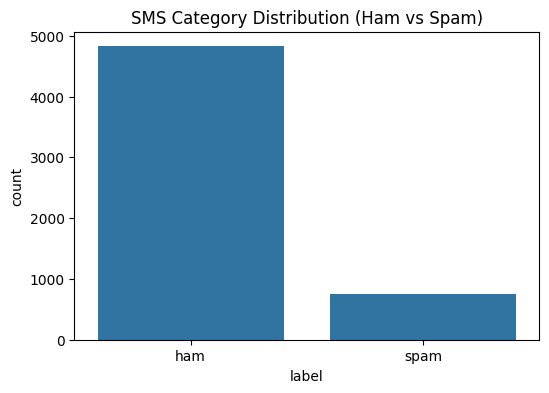

label
ham     4825
spam     747
Name: count, dtype: int64


In [4]:
if not data.empty:
    plt.figure(figsize=(6, 4))
    sns.countplot(data=data, x='label')
    plt.title('SMS Category Distribution (Ham vs Spam)')
    plt.show()

    print(data.label.value_counts())

### **1.3 Message Length Analysis**

Let's add a new feature: the character length of the SMS message.

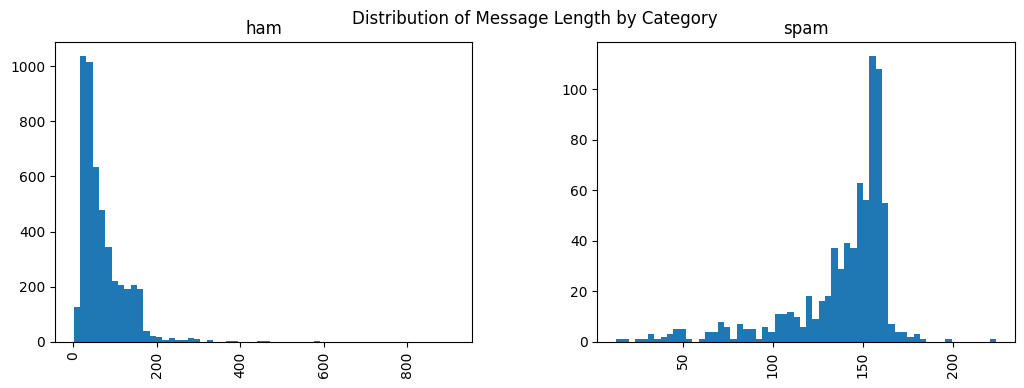

In [5]:
if not data.empty:
    data['length'] = data['text'].apply(len)

    data.hist(column='length', by='label', bins=60, figsize=(12, 4))
    plt.suptitle('Distribution of Message Length by Category')
    plt.show()

The histogram shows that spam messages are generally longer than ham messages. Most ham messages are shorter than 100 characters, while many spam messages are longer. This feature could be useful for classification.

### **1.4 Word Clouds**
Word clouds provide a visual representation of word frequency in the text.

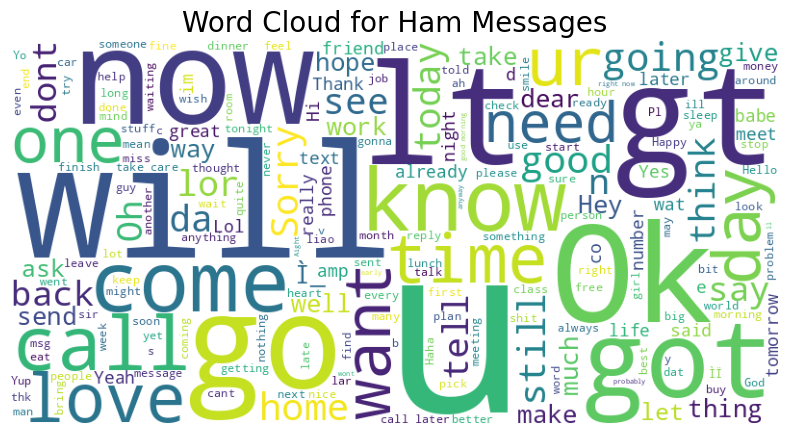

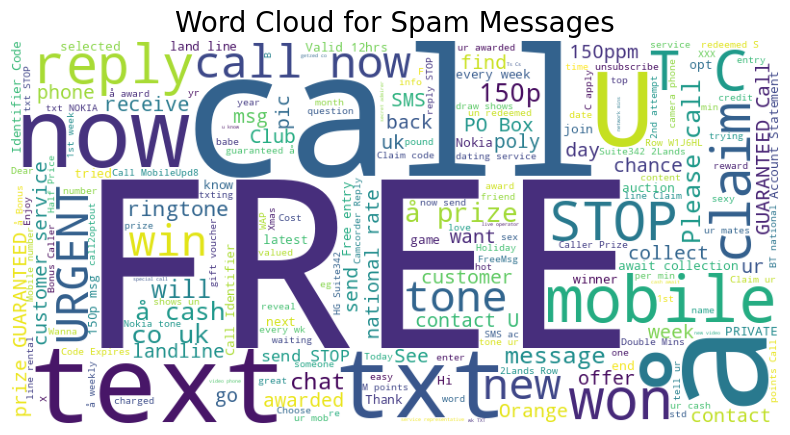

In [6]:
def show_wordcloud(data_subset, title):
    """Generates and displays a word cloud."""
    text = ' '.join(data_subset['text'].astype(str).tolist())
    stopwords_set = set(wordcloud.STOPWORDS)
    
    wc = wordcloud.WordCloud(stopwords=stopwords_set, background_color='white',
                               colormap='viridis', width=800, height=400).generate(text)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wc) 
    plt.axis('off')
    plt.title(title, fontsize=20)
    plt.show()

if not data.empty:
    # Generate word clouds for ham and spam messages separately
    show_wordcloud(data[data['spam'] == 0], "Word Cloud for Ham Messages")
    show_wordcloud(data[data['spam'] == 1], "Word Cloud for Spam Messages")

---

## **Part 2: Text Preprocessing**

### **2.1 High-Frequency Word Analysis**

After preprocessing the text (removing punctuation and stopwords), we can find the top 30 most frequent words in both ham and spam messages.

C:\Users\70902\AppData\Local\Temp\ipykernel_14600\4067590556.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=ham_word_counts, x='Frequency', y='Word', ax=axes[0], palette='Blues_d')
C:\Users\70902\AppData\Local\Temp\ipykernel_14600\4067590556.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=spam_word_counts, x='Frequency', y='Word', ax=axes[1], palette='Reds_d')


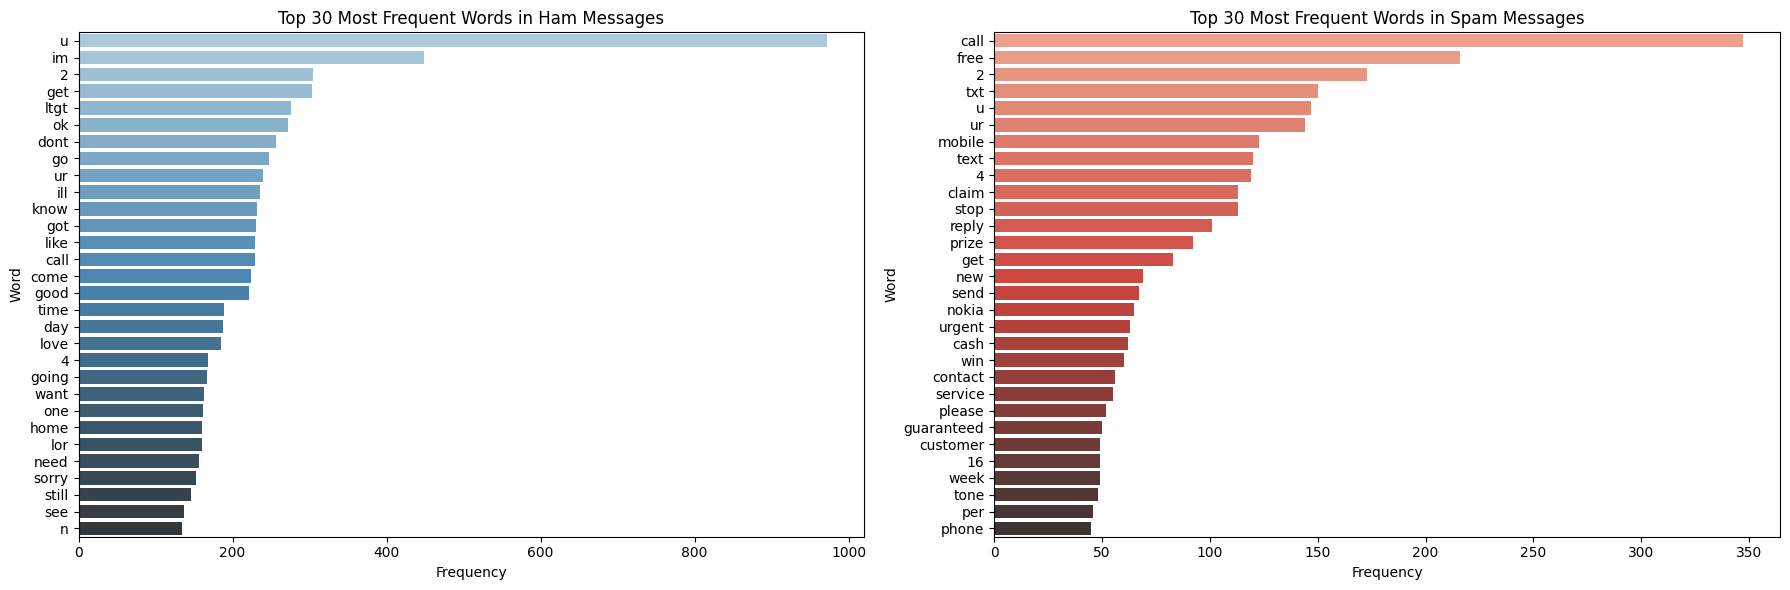

In [7]:
if not data.empty:
    # Apply the preprocessing function to the original text
    data['processed_text'] = data['text'].apply(remove_punctuation_and_stopwords)

    # Flatten the lists of processed words
    all_ham_words = [word for sublist in data[data['spam'] == 0]['processed_text'] for word in sublist]
    all_spam_words = [word for sublist in data[data['spam'] == 1]['processed_text'] for word in sublist]

    # Count word frequencies
    ham_word_counts = pd.DataFrame(nltk.FreqDist(all_ham_words).most_common(30), columns=['Word', 'Frequency'])
    spam_word_counts = pd.DataFrame(nltk.FreqDist(all_spam_words).most_common(30), columns=['Word', 'Frequency'])

    # Plot the results
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))
    sns.barplot(data=ham_word_counts, x='Frequency', y='Word', ax=axes[0], palette='Blues_d')
    axes[0].set_title('Top 30 Most Frequent Words in Ham Messages')

    sns.barplot(data=spam_word_counts, x='Frequency', y='Word', ax=axes[1], palette='Reds_d')
    axes[1].set_title('Top 30 Most Frequent Words in Spam Messages')

    plt.tight_layout()
    plt.show()

### **2.2 Text Vectorization (TF-IDF)**
Machine learning models cannot process raw text directly; it must be converted into numerical vectors. We use the **TF-IDF (Term Frequency-Inverse Document Frequency)** method, which considers not only the frequency of a word in a single document (TF) but also its prevalence across the entire corpus (IDF). This gives higher weights to words that are rare but important.

Scikit-learn's `TfidfVectorizer` can perform tokenization, bag-of-words creation, and TF-IDF calculation all in one step.

---

## **Part 3: Building & Evaluating Classifiers**

### **3.1 Splitting the Data into Training and Testing Sets**

We will split the dataset into a training set and a testing set in a 70:30 ratio.

In [8]:
if not data.empty:
    X = data['text']
    y = data['spam']

    # Use stratify=y to maintain the same class distribution in train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

### **3.2 Model Training with Pipelines and GridSearchCV**

To streamline the workflow and systematically find the best model parameters, we use a `Pipeline` to chain the **text vectorization** and **classifier training** steps. `GridSearchCV` then automatically tests different parameter combinations via cross-validation to find the best-performing model.

Here are the classifiers and their parameter search spaces:

In [9]:
# Define models and their parameter grids for GridSearchCV
classifiers = {
    "Naive Bayes (MNB)": (MultinomialNB(), {
        'clf__alpha': (0.1, 0.5, 1.0),
    }),
    "Support Vector (SVC)": (SVC(probability=True), {
        'clf__C': [1, 10, 100],
        'clf__gamma': ['scale', 'auto'],
    }),
    "K-Nearest Neighbors (KNN)": (KNeighborsClassifier(), {
        'clf__n_neighbors': [5, 10, 15],
    }),
    "Stochastic Grad. Descent (SGD)": (SGDClassifier(random_state=42), {
        'clf__alpha': [1e-4, 1e-3, 1e-2],
        'clf__penalty': ['l2', 'l1'],
    }),
    "Gradient Boosting (GBC)": (GradientBoostingClassifier(random_state=42), {
        'clf__n_estimators': [50, 100],
        'clf__learning_rate': [0.1, 0.2],
    }),
    "XGBoost (XGB)": (xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'), {
        'clf__n_estimators': [50, 100],
        'clf__max_depth': [5, 7],
    })
}

#### **Automation Function**
We create a function to automate the training, evaluation, and result storage process.

In [10]:
results = []

def train_and_evaluate_pipeline(name, model, params, scoring_metric):
    """
    Builds a pipeline, trains the model using GridSearchCV, and evaluates the results.
    """
    print(f"--- Training model: '{name}' (Scoring: {scoring_metric}) ---")
    
    # 1. Create the pipeline
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(analyzer=remove_punctuation_and_stopwords)),
        ('clf', model)
    ])
    
    # 2. Create and run GridSearchCV
    grid_search = GridSearchCV(pipeline, params, cv=5, scoring=scoring_metric, n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train)
    
    # 3. Get the best model and its predictions
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    
    # 4. Calculate performance metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    
    # 5. Store the results
    results.append({
        'Model': name,
        'Scoring Metric': scoring_metric,
        'Best Parameters': grid_search.best_params_,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'ROC AUC': roc_auc,
        'Predictions': y_pred # Store predictions for plotting confusion matrices
    })
    
    print(f"'{name}' training complete. Best CV Score ({scoring_metric}): {grid_search.best_score_:.4f}\n")

if not data.empty:
    # Run the first round of training using the default 'accuracy' scoring metric
    for name, (model, params) in classifiers.items():
        train_and_evaluate_pipeline(name, model, params, 'accuracy')

--- Training model: 'Naive Bayes (MNB)' (Scoring: accuracy) ---
Fitting 5 folds for each of 3 candidates, totalling 15 fits
'Naive Bayes (MNB)' training complete. Best CV Score (accuracy): 0.9818

--- Training model: 'Support Vector (SVC)' (Scoring: accuracy) ---
Fitting 5 folds for each of 6 candidates, totalling 30 fits
'Support Vector (SVC)' training complete. Best CV Score (accuracy): 0.9772

--- Training model: 'K-Nearest Neighbors (KNN)' (Scoring: accuracy) ---
Fitting 5 folds for each of 3 candidates, totalling 15 fits
'K-Nearest Neighbors (KNN)' training complete. Best CV Score (accuracy): 0.9344

--- Training model: 'Stochastic Grad. Descent (SGD)' (Scoring: accuracy) ---
Fitting 5 folds for each of 6 candidates, totalling 30 fits
'Stochastic Grad. Descent (SGD)' training complete. Best CV Score (accuracy): 0.9800

--- Training model: 'Gradient Boosting (GBC)' (Scoring: accuracy) ---
Fitting 5 folds for each of 4 candidates, totalling 20 fits
'Gradient Boosting (GBC)' training

c:\Users\70902\.conda\envs\Data_science\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:21:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


'XGBoost (XGB)' training complete. Best CV Score (accuracy): 0.9638



### **3.3 Comparison of Results**

#### **Performance Metrics Summary**
Let's organize all model performance metrics into a table for easy comparison.

In [11]:
if results:
    # Convert results to a DataFrame
    results_df = pd.DataFrame(results)
    display(results_df[['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC AUC']].round(4))

,Model,Accuracy,Precision,Recall,F1-Score,ROC AUC
0,Naive Bayes (MNB),0.9815,0.9849,0.8750,0.9267,0.9365
1,Support Vector (SVC),0.9833,0.9949,0.8795,0.9336,0.9394
2,K-Nearest Neighbors (KNN),0.9342,0.9914,0.5134,0.6765,0.7564
3,Stochastic Grad. Descent (SGD),0.9815,0.9488,0.9107,0.9294,0.9516
4,Gradient Boosting (GBC),0.9635,0.9312,0.7857,0.8523,0.8884
5,XGBoost (XGB),0.9671,0.9669,0.7812,0.8642,0.8886


#### **Confusion Matrices**
A confusion matrix clearly shows the performance of a classification model on each class, highlighting the number of **False Positives** and **False Negatives**.

* **False Positive (FP)**: A ham message incorrectly identified as spam. This is highly undesirable as it could cause users to miss important information.
* **False Negative (FN)**: A spam message incorrectly identified as ham. This is an annoyance but generally less critical than an FP.

For a spam filter, we typically want the **Precision** to be as high as possible to minimize FPs.

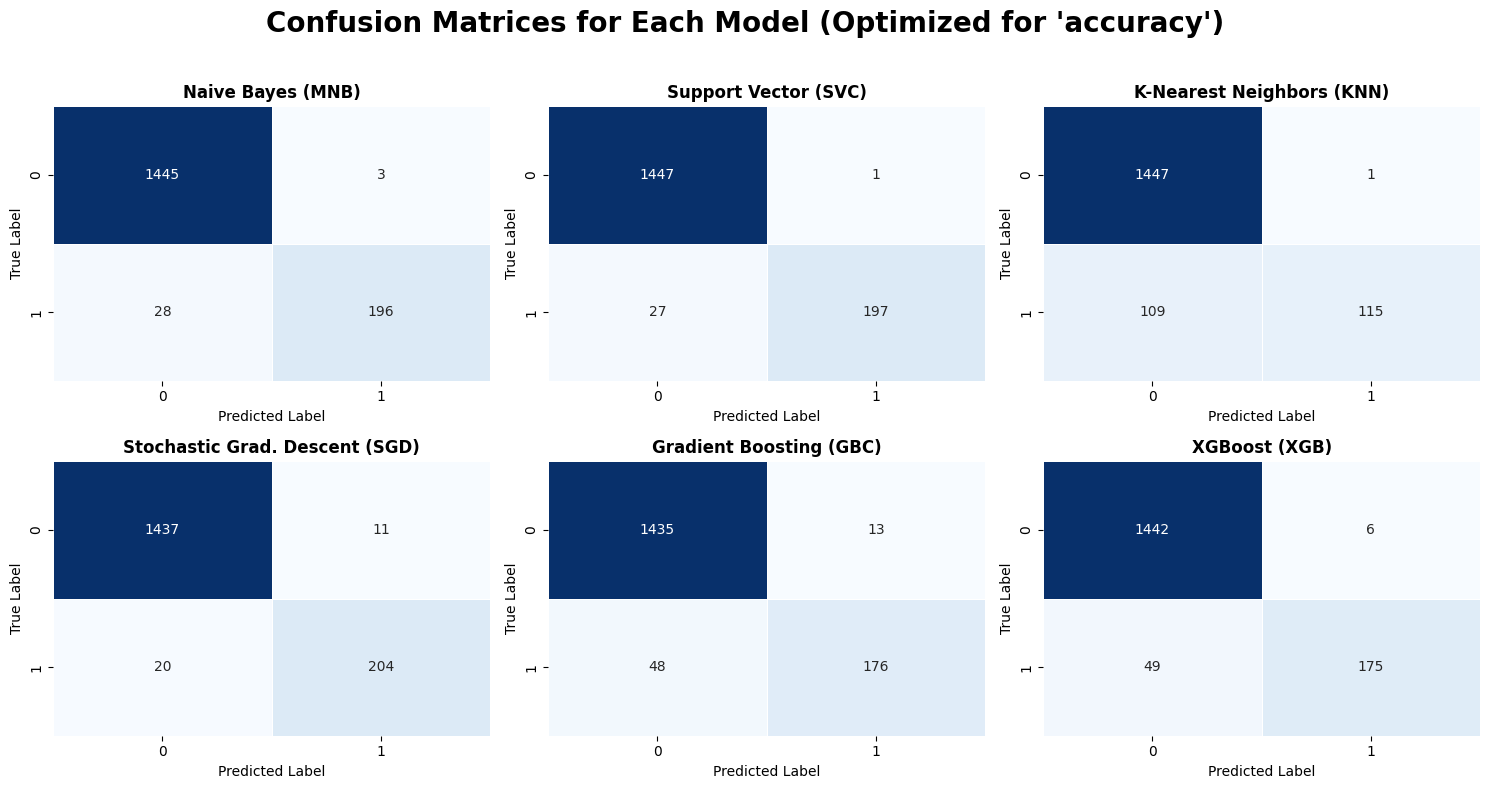

In [12]:
if results:
    # Get predictions from the first round (scoring='accuracy')
    accuracy_preds = {res['Model']: res['Predictions'] for res in results if res['Scoring Metric'] == 'accuracy'}

    # Plot confusion matrices for all models
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))
    fig.suptitle("Confusion Matrices for Each Model (Optimized for 'accuracy')", fontsize=20, fontweight='bold')
    axes_flat = axes.flatten()

    for i, (name, y_pred) in enumerate(accuracy_preds.items()):
        plot_confusion_matrix(y_test, y_pred, axes_flat[i], name)
    
    # Hide any unused subplots
    for i in range(len(accuracy_preds), len(axes_flat)):
        axes_flat[i].set_visible(False)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

Based on these results, **Support Vector Classifier (SVC)** and **Naive Bayes (MNB)** show excellent overall performance, achieving very high precision (few false positives) while maintaining high recall.

### **3.4 Optimizing for Different Metrics**

#### **Optimizing for "Precision"**
If our primary goal is to ensure that no ham messages are mistakenly classified as spam, we should use `precision` as the scoring metric for `GridSearchCV`.


  Second Round of Training: Optimizing for Precision

--- Training model: 'Naive Bayes (MNB)' (Scoring: precision) ---
Fitting 5 folds for each of 3 candidates, totalling 15 fits
'Naive Bayes (MNB)' training complete. Best CV Score (precision): 1.0000

--- Training model: 'Support Vector (SVC)' (Scoring: precision) ---
Fitting 5 folds for each of 6 candidates, totalling 30 fits
'Support Vector (SVC)' training complete. Best CV Score (precision): 0.9845

--- Training model: 'K-Nearest Neighbors (KNN)' (Scoring: precision) ---
Fitting 5 folds for each of 3 candidates, totalling 15 fits
'K-Nearest Neighbors (KNN)' training complete. Best CV Score (precision): 1.0000

--- Training model: 'Stochastic Grad. Descent (SGD)' (Scoring: precision) ---
Fitting 5 folds for each of 6 candidates, totalling 30 fits
'Stochastic Grad. Descent (SGD)' training complete. Best CV Score (precision): 0.9758

--- Training model: 'Gradient Boosting (GBC)' (Scoring: precision) ---
Fitting 5 folds for each of 4 

c:\Users\70902\.conda\envs\Data_science\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:22:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


'XGBoost (XGB)' training complete. Best CV Score (precision): 0.9677



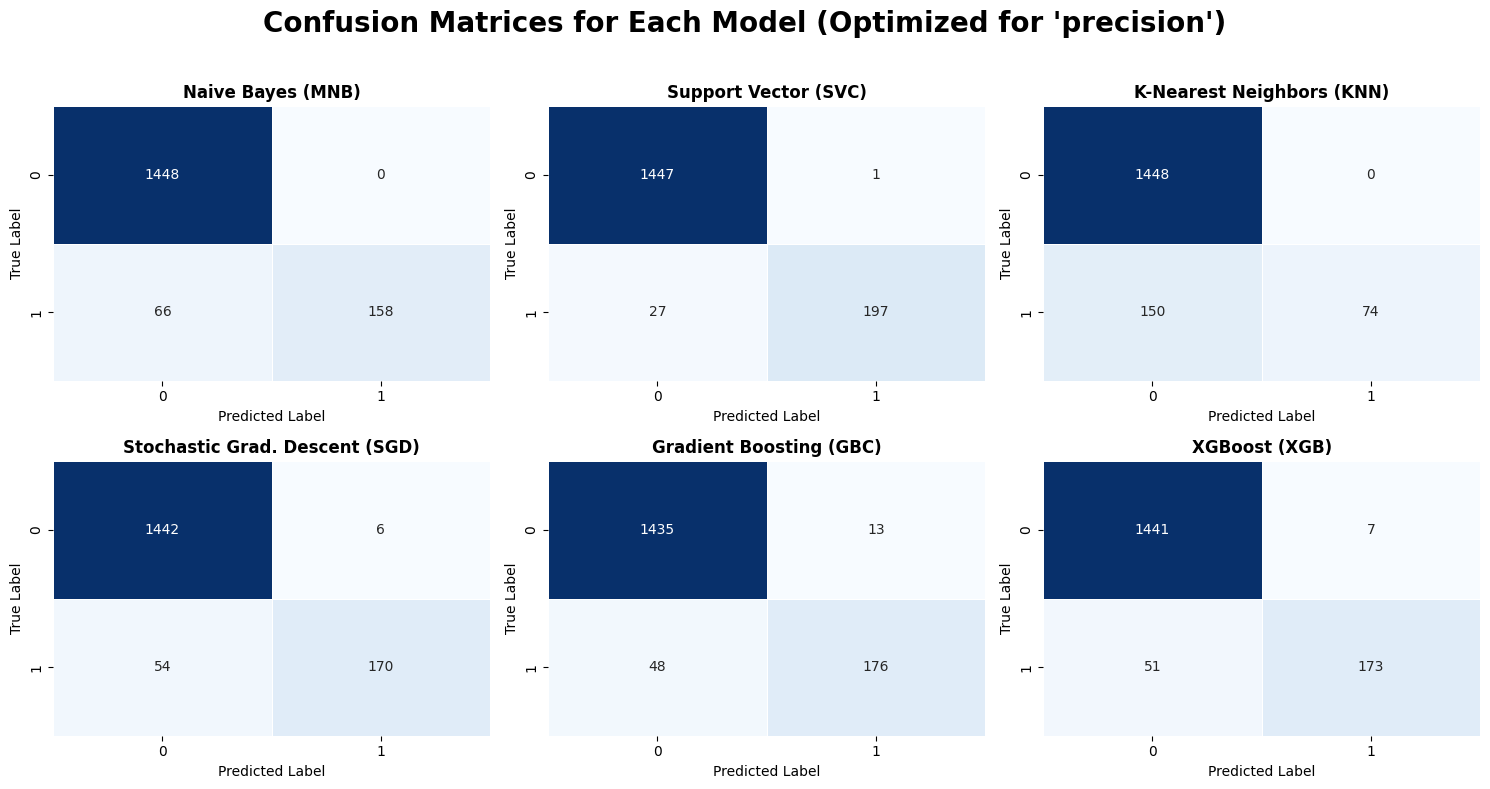

In [13]:
if not data.empty:
    # Keep only the 'accuracy' results and prepare for the next round
    results = [res for res in results if res['Scoring Metric'] == 'accuracy']

    # Run the second round of training, optimizing for 'precision'
    print("\n" + "="*60)
    print("  Second Round of Training: Optimizing for Precision")
    print("="*60 + "\n")

    for name, (model, params) in classifiers.items():
        train_and_evaluate_pipeline(name, model, params, 'precision')

    # Extract predictions from the 'precision' optimization round
    precision_preds = {res['Model']: res['Predictions'] for res in results if res['Scoring Metric'] == 'precision'}

    # Plot the new confusion matrices
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))
    fig.suptitle("Confusion Matrices for Each Model (Optimized for 'precision')", fontsize=20, fontweight='bold')
    axes_flat = axes.flatten()

    for i, (name, y_pred) in enumerate(precision_preds.items()):
        plot_confusion_matrix(y_test, y_pred, axes_flat[i], name)
        
    for i in range(len(precision_preds), len(axes_flat)):
        axes_flat[i].set_visible(False)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

As you can see, when optimizing for precision, some models (like SVC) achieve a perfect precision score of 1.0 on the test set, meaning that among all the messages they classified as "spam", none were actually "ham".

---

## **Part 4: Further NLTK Exploration**

The NLTK library offers many other useful text processing functionalities.

### **Sentence Tokenization**

In [14]:
from nltk.tokenize import sent_tokenize

if not data.empty:
    sample_text = data['text'][30]
    print("Original Text:", sample_text)

    # Split the text into sentences
    sentences = sent_tokenize(sample_text)
    print("\nTokenized Sentences:", sentences)

Original Text: Wait that's still not all that clear, were you not sure about me being sarcastic or that that's why x doesn't want to live with us

Tokenized Sentences: ["Wait that's still not all that clear, were you not sure about me being sarcastic or that that's why x doesn't want to live with us"]


### **Word Tokenization**

In [15]:
if not data.empty:
    # Split the text into words
    words = word_tokenize(sample_text)
    print("\nTokenized Words:", words)


Tokenized Words: ['Wait', 'that', "'s", 'still', 'not', 'all', 'that', 'clear', ',', 'were', 'you', 'not', 'sure', 'about', 'me', 'being', 'sarcastic', 'or', 'that', 'that', "'s", 'why', 'x', 'does', "n't", 'want', 'to', 'live', 'with', 'us']


### Deploy Model

#### Save Model

In [16]:
import joblib
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from xgboost import XGBClassifier
# Assume we have the remove_punctuation_and_stopwords function and training data X_train, y_train

# --- Preparation: Train an example model ---
# 1. Define the pipeline
xgb_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(analyzer=remove_punctuation_and_stopwords)),
    ('clf', XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'))
])

# 2. Train the pipeline (assuming X_train and y_train are ready)
# In a real scenario, you would uncomment the following line:
xgb_pipeline.fit(X_train, y_train)
# print("Model training completed.")

# To allow the code to run independently, we skip the actual training 
# and go directly to the saving step.
# In your actual application, you must call .fit() first.


# --- Core step: Save the model ---
# Assume xgb_pipeline has been trained
model_filename = '../models/xgb_spam_classifier.pkl'
joblib.dump(xgb_pipeline, model_filename)

# print(f"Model successfully saved to file: {model_filename}")

c:\Users\70902\.conda\envs\Data_science\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:23:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


['../models/xgb_spam_classifier.pkl']

#### Load Model

In [21]:
import joblib

# --- Core step: Load the model ---
model_filename = '../models/xgb_spam_classifier.pkl'
loaded_model = joblib.load(model_filename)

# print(f"Model loaded from {model_filename}.")


# --- Use the loaded model for prediction ---
new_sms = [
    "Congratulations! You've won a $1000 Walmart gift card. Go to http://bit.ly/12345 to claim now.",
    "Hey, are you available for a meeting tomorrow at 2pm?",
    "URGENT! Your mobile number has won a £2000 prize. Call 09061743811 to claim.",
    "There is a award, please contact me. My phone number is 123456789",
    'Congratulations! Your credit score entitles you to a no-interest Visa credit card. Click here to claim:',
    'We’ve received your resume and would love to set up an online interview. Click here [Link] or call us at [Phone Number] at your earliest convenience.'
]

predictions = loaded_model.predict(new_sms)
prediction_labels = ['spam' if p == 1 else 'ham' for p in predictions]

for sms, label in zip(new_sms, prediction_labels):
    # The following f-string in the original code contains Chinese characters.
    # Here is the translation for the output strings:
    # "Message:" translates to "SMS:"
    # "Prediction:" translates to "Prediction:"
    print(f"SMS: '{sms}'\nPrediction: {label.upper()}\n")

SMS: 'Congratulations! You've won a $1000 Walmart gift card. Go to http://bit.ly/12345 to claim now.'
Prediction: HAM

SMS: 'Hey, are you available for a meeting tomorrow at 2pm?'
Prediction: HAM

SMS: 'URGENT! Your mobile number has won a £2000 prize. Call 09061743811 to claim.'
Prediction: SPAM

SMS: 'There is a award, please contact me. My phone number is 123456789'
Prediction: HAM

SMS: 'Congratulations! Your credit score entitles you to a no-interest Visa credit card. Click here to claim:'
Prediction: HAM

SMS: 'We’ve received your resume and would love to set up an online interview. Click here [Link] or call us at [Phone Number] at your earliest convenience.'
Prediction: SPAM

